# Firefox Workflow, Comparison for October, Last 8 Years

In [252]:
import pandas as pd
import seaborn as sns

In [253]:
files = ['data/nightly-{}10.parq'.format(y) for y in range(2010, 2019)]

In [254]:
df = pd.concat([pd.read_parquet(fn) for fn in files], ignore_index=True)
df.shape

(32007, 8)

In [255]:
df.head()

,changeset,changeset_desc,changeset_pushid,changeset_pushtime,bug,bug_creation_time,nightly_build_id,nightly_publish_time
0,fdf8b40547652aff7a5162f526935f7a935b7dd9,Bug 608416: Stop exceptions from cleanup funct...,16660,2010-10-30 18:59:52,608416.0,2010-10-29 22:17:37,20101031030736,2015-10-10 02:36:19+00:00
1,97ea3fe9232ad06d4e5e2282f8f8f932f8975235,bug 608422 - cookies.sqlite-wal takes too much...,16661,2010-10-31 02:35:13,608422.0,2010-10-29 22:41:34,20101031030736,2015-10-10 02:36:19+00:00
2,de32b6e1ca006bb985a4f4afd80f2c46548af68c,Fix for bug 606705 (Browser crash when using m...,16662,2010-10-31 04:37:53,606705.0,2010-10-23 20:19:55,20101031030736,2015-10-10 02:36:19+00:00
3,05e775f368f88d34e30fa6fdfba2ef378f75e944,Disallow sending JS functions to a different t...,16663,2010-10-31 05:12:52,608142.0,2010-10-28 23:20:54,20101031030736,2015-10-10 02:36:19+00:00
4,67dd5fbeebaaa27522897a4c10cf81b96a05d562,Follow-up for bug 608142: disallow sending bet...,16663,2010-10-31 05:12:52,608142.0,2010-10-28 23:20:54,20101031030736,2015-10-10 02:36:19+00:00


*Lead Time* is the total time a work item is in process, including the time up-front when we are waiting for work to start.

We will assume that the bug creation time is when the work was queued but not started (or started very soon after).

In [256]:
df['bug_creation_time'] = df['bug_creation_time'].dt.tz_localize('UTC')

In [257]:
df['year'] = df['nightly_publish_time'].dt.year

In [258]:
df.groupby('year').size()

year
2015    19009
2016     3839
2017     4792
2018     4367
dtype: int64

Looks like 2013 and 2014 nightly publishing times are messed up and polluting the 2015 data!

In [259]:
oops = df[(df['nightly_publish_time'].dt.year == 2015) & (df['changeset_pushtime'].dt.year <= 2014)]
oops.shape

(13245, 9)

In [260]:
oops.head()

,changeset,changeset_desc,changeset_pushid,changeset_pushtime,bug,bug_creation_time,nightly_build_id,nightly_publish_time,year
0,fdf8b40547652aff7a5162f526935f7a935b7dd9,Bug 608416: Stop exceptions from cleanup funct...,16660,2010-10-30 18:59:52,608416.0,2010-10-29 22:17:37+00:00,20101031030736,2015-10-10 02:36:19+00:00,2015
1,97ea3fe9232ad06d4e5e2282f8f8f932f8975235,bug 608422 - cookies.sqlite-wal takes too much...,16661,2010-10-31 02:35:13,608422.0,2010-10-29 22:41:34+00:00,20101031030736,2015-10-10 02:36:19+00:00,2015
2,de32b6e1ca006bb985a4f4afd80f2c46548af68c,Fix for bug 606705 (Browser crash when using m...,16662,2010-10-31 04:37:53,606705.0,2010-10-23 20:19:55+00:00,20101031030736,2015-10-10 02:36:19+00:00,2015
3,05e775f368f88d34e30fa6fdfba2ef378f75e944,Disallow sending JS functions to a different t...,16663,2010-10-31 05:12:52,608142.0,2010-10-28 23:20:54+00:00,20101031030736,2015-10-10 02:36:19+00:00,2015
4,67dd5fbeebaaa27522897a4c10cf81b96a05d562,Follow-up for bug 608142: disallow sending bet...,16663,2010-10-31 05:12:52,608142.0,2010-10-28 23:20:54+00:00,20101031030736,2015-10-10 02:36:19+00:00,2015


We can fill in the busted data by inferring the publishing time from the build time and mean build time from other years.

In [261]:
df['build_time'] = pd.to_datetime(df['nightly_build_id'], infer_datetime_format=True, utc=True)

In [262]:
df['build_publish_duration'] = df['nightly_publish_time'] - df['build_time']

In [263]:
pubstep = df.loc[:, ['year', 'build_publish_duration']]

In [264]:
pubstep['build_days'] = pubstep['build_publish_duration'].dt.days

In [265]:
pubstep[pubstep['year'] > 2015].groupby('year').mean()

,build_days
year,
2016,0.040636
2017,0.000000
2018,0.000000


Since the number of days build times contribute to the total end-to-end time appears insignificant we can just ignore it and "fix" the nightly publish time by setting it to the build time + 0.05 days.

In [266]:
bogus_years = df[(df['build_time'].dt.year < 2015) & ((df['nightly_publish_time'] - df['build_time']).dt.days > 30)].copy()

In [267]:
bogus_years['nightly_publish_time'].describe()

count                         13245
unique                          157
top       2015-10-16 16:22:44+00:00
freq                            387
first     2015-10-10 02:26:31+00:00
last      2015-10-20 09:29:34+00:00
Name: nightly_publish_time, dtype: object

In [268]:
bogus_years['nightly_publish_time'] = bogus_years['build_time'] + pd.Timedelta('0.05 day')

In [269]:
bogus_years['nightly_publish_time'].describe()

count                         13245
unique                          157
top       2014-10-21 04:14:08+00:00
freq                            387
first     2010-10-02 04:17:50+00:00
last      2014-10-31 07:30:04+00:00
Name: nightly_publish_time, dtype: object

In [270]:
df.update(bogus_years)

In [271]:
df['year'] = df['nightly_publish_time'].dt.year

In [272]:
df.groupby('year').size()

year
2010    1659
2011    1367
2012    2831
2013    3043
2014    4345
2015    5764
2016    3839
2017    4792
2018    4367
dtype: int64

That looks better.  Now we can calculate the end-to-end lead time for each commit.

In [273]:
df['lead_time'] = df['nightly_publish_time'] - df['bug_creation_time']

In [274]:
df['lead_seconds'] = df['lead_time'].dt.total_seconds()

In [275]:
df['lead_days'] = df['lead_time'].dt.days

In [276]:
df['lead_time'].describe()

count                        32007
mean      376 days 18:17:06.228200
std      1221 days 07:39:27.600251
min            -878 days +03:14:35
25%         5 days 04:09:05.500000
50%               18 days 09:02:34
75%               85 days 22:09:15
max             6965 days 08:27:35
Name: lead_time, dtype: object

We need to drop any records where the bug was filed after the code landed.

In [277]:
late_bugs = df[df['lead_time'].dt.days < 0]

In [278]:
df = df.drop(late_bugs.index)

In [279]:
df['lead_time'].describe()

count                        31999
mean      376 days 21:49:54.993343
std      1221 days 10:15:30.214477
min                0 days 01:00:24
25%                5 days 04:22:34
50%               18 days 09:27:22
75%               85 days 22:09:15
max             6965 days 08:27:35
Name: lead_time, dtype: object

In [280]:
years = df.groupby('year')

In [281]:
years['lead_days'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2010,1657.0,103.360893,346.965070,0.0,6.0,23.0,85.0,4529.0
2011,1365.0,121.580220,381.120322,0.0,5.0,17.0,84.0,4419.0
2012,2829.0,95.892188,336.323517,0.0,3.0,11.0,47.0,4812.0
2013,3041.0,755.339033,1717.449028,0.0,5.0,23.0,152.0,5420.0
2014,4345.0,639.431530,1604.493075,0.0,5.0,23.0,136.0,5856.0
2015,5764.0,592.546149,1574.542164,0.0,12.0,29.0,105.0,6050.0
2016,3839.0,138.618130,471.560738,0.0,5.0,17.0,83.0,6120.0
2017,4792.0,402.960559,1375.892490,0.0,3.0,10.0,57.0,6782.0
2018,4367.0,110.434852,397.294404,0.0,3.0,10.0,55.0,6965.0


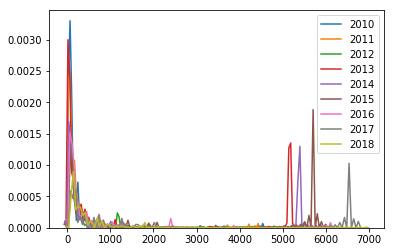

In [282]:
for group in years.groups:
    year = years.get_group(group)[['lead_time', 'lead_days']]
    sns.kdeplot(year['lead_days'], label=group)

## The last 90 days

Let's show only the commits where the bug was filed in the last 90 days.

In [283]:
yd = df.loc[:,['year', 'lead_days']]
shortgrp = yd[yd['lead_days'] <= 90].groupby('year')
shortgrp.describe()

lead_days                                                  
         count       mean        std  min  25%   50%   75%   max
year                                                            
2010    1361.0  25.897869  27.311665  0.0  4.0  15.0  40.0  90.0
2011    1037.0  18.290260  21.048107  0.0  3.0   9.0  26.0  90.0
2012    2302.0  14.307559  18.061297  0.0  2.0   7.0  19.0  90.0
2013    2127.0  18.303714  20.791622  0.0  3.0   9.0  27.0  90.0
2014    3072.0  17.946615  20.694529  0.0  3.0   8.0  27.0  90.0
2015    4161.0  24.291036  20.950930  0.0  8.0  20.0  31.0  90.0
2016    2904.0  19.877410  23.085893  0.0  3.0   8.0  29.0  90.0
2017    3753.0  13.060751  17.460725  0.0  2.0   6.0  16.0  90.0
2018    3498.0  14.132361  19.477091  0.0  2.0   6.0  15.0  90.0

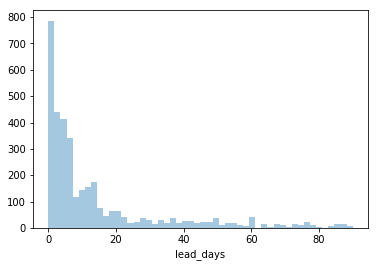

In [284]:
sns.distplot(shortgrp.get_group(2018)['lead_days'], kde=False);

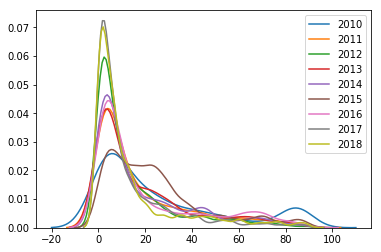

In [285]:
for year, data in shortgrp:
    sns.kdeplot(data['lead_days'], label=year)

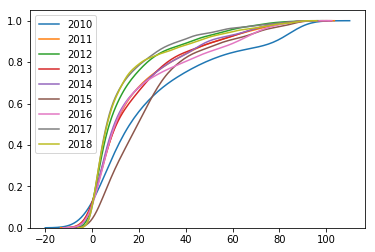

In [286]:
for year, data in shortgrp:
    sns.kdeplot(data['lead_days'], label=year, cumulative=True)

### Build times

In [287]:
push_to_publish = df.loc[:,['nightly_publish_time', 'changeset_pushtime', 'year']]

In [288]:
push_to_publish['duration'] = push_to_publish['nightly_publish_time'] - push_to_publish['changeset_pushtime']
push_to_publish['duration'].describe()

count                     31999
mean     1 days 13:57:01.841557
std      4 days 01:44:04.232577
min           -1 days +18:14:41
25%             0 days 02:54:30
50%             0 days 07:40:11
75%             0 days 15:07:36
max            22 days 05:58:21
Name: duration, dtype: object

We need to kill any records where the duration in days is negative.  Probably bad data.

In [289]:
oops = push_to_publish[(push_to_publish['duration'].dt.days < 0) | 
                       (push_to_publish['duration'].dt.seconds < 0)]
oops.shape

(2129, 4)

In [290]:
push_to_publish = push_to_publish.drop(oops.index)

In [291]:
push_to_publish['hours'] = push_to_publish['duration'].dt.total_seconds() / 3600

In [292]:
groupedhours = push_to_publish.groupby('year')['hours']
groupedhours.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2010,1165.0,8.356402,4.327761,0.003056,4.645833,8.446944,11.283889,23.173056
2011,1322.0,13.505117,5.633820,0.084444,9.679444,14.521667,18.430903,20.395833
2012,2434.0,9.166033,5.835775,0.260556,2.896111,9.238611,14.016667,27.886667
2013,2143.0,7.349313,5.574879,0.268333,2.350278,6.848889,12.499722,19.505000
2014,4044.0,9.471787,4.646642,0.188611,4.816667,9.312778,14.374167,17.411111
2015,5764.0,176.168533,171.610997,2.518611,14.948611,98.592778,348.692500,533.972500
2016,3839.0,14.646045,12.831647,1.793611,3.322222,11.314444,20.917500,68.369444
2017,4792.0,4.658118,3.289364,2.274722,2.887500,3.370833,4.893889,15.710556
2018,4367.0,5.357970,3.417037,1.713611,2.282222,4.263056,7.681111,21.703611


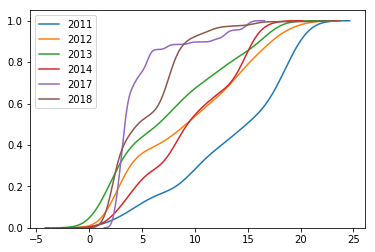

In [293]:
# All years except 2015 and 2016, which look like they have weird data?
# Also drop 2010 because its build times fall well below 2011's.
for year in sorted(set(groupedhours.groups) - {2010, 2015, 2016}):
    sns.kdeplot(groupedhours.get_group(year), label=year, cumulative=True, clip=(0, 25))

2010-2011 build time decrease


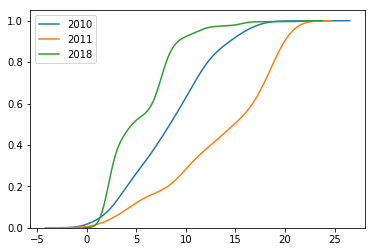

In [294]:
print("2010-2011 build time decrease")
for year in (2010, 2011, 2018):
    sns.kdeplot(groupedhours.get_group(year), label=year, cumulative=True)

2016 build time weirdness


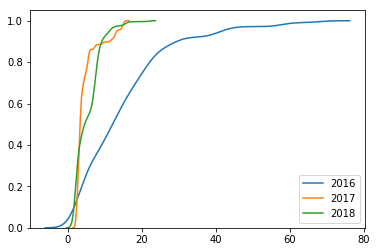

In [295]:
print("2016 build time weirdness")
for year in (2016, 2017, 2018):
    sns.kdeplot(groupedhours.get_group(year), label=year, cumulative=True)

2015 data is even more weird


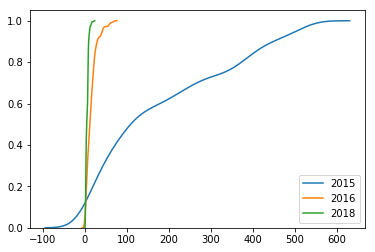

In [296]:
print("2015 data is even more weird")
for year in (2015, 2016, 2018):
    sns.kdeplot(groupedhours.get_group(year), label=year, cumulative=True)